# probabilistic Principle Component Analysis

In this notebook, we will implement　probabilistic Principle Component Analysis (PCA). 
We will work on both 
* maximum likelihood estimation, and 
* Bayesian PCA

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.linalg import eigh

%matplotlib inline
mpl.rc("savefig",dpi=100)

# 1 Setting

Here we consider a unsupervised learning problem. 

* Let $N \in \mathbb{N}$ be the number of data points, and
* Let $d \in \mathbb{N}$ be the input dimension.
* Denote input data by $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^d$. 
* Denote the input data collectively by a matrix $X$, where $X_{n,i}$ is $i$-th component of $x_n$.

# 2 Theory


## 2.1 Model


* Let $m \in \mathbb{N}$ be the dimension of the latent variables.
* Denote latent variables corresponding to input data points by $z_0, \dots, z_{N-1} \in \mathbb{R}^{m}$. 
* Denote the latent variables collectively by $Z = (z_{n})_{ n \in \{ 0, 1, \dots, N-1 \} }$

### 2.1.1 Maximum-likelihood approach

In the maximum-likelihood approach, we consider the model
$$
\begin{align}
    &{} p\left(X,Z \middle| W, \mu, \sigma^2 \right) = \prod_{n=0}^{N-1} p\left(x_n \middle| z_n, W, \mu, \sigma^2 \right)p(z_n) \\
    &{} p\left(z \right) := \mathcal{N}\left(z \middle| 0, I_m \right) \\ 
    &{} p\left(x \middle|z, W, \mu, \sigma^2 \right) := \mathcal{N}\left(x \middle| W z + \mu, \sigma^2 I_d \right), 
\end{align}
$$
where 
* $\mathcal{N}\left(\cdot \middle| \mu , \Sigma \right)$ is a gaussian probability density with mean $\mu$ and covariance matrix $\Sigma$.
* $\mu \in \mathbb{R}^d$, $W$ is a $d \times m$ matrix, $\sigma > 0$, and they are the parameters of the model.

### 2.1.2 Bayesian approach

In the Bayesian approach, we consider the model defined by 
$$
\begin{align}
    &{} p\left(X, Z, W \middle| \alpha, \mu, \sigma^2 \right) := p\left(X,Z \middle| W, \mu, \sigma^2 \right) p(W| \alpha) \\
    &{} p\left(W \middle| \alpha \right) = \prod_{i=0}^{m-1} \left[ \left( \frac{\alpha_i}{2\pi}\right)^{d/2} \exp\left( - \frac{1}{2} \alpha_i w_{i}^{T} w_i \right) \right]
\end{align}
$$
where
* $p\left(X,Z \middle| W, \mu, \sigma^2 \right)$ is the same as the previous model, 
* $W = (w_0, w_1, \dots, w_{M-1})$, and $w_{i} \in \mathbb{R}^d$ represents column vector.

## 2.2 Estimation

### 2.2.1 Maximum likelihood estimation (analytical result)

In the maximum-likelihood approach, our goal is to obtain $\mu, W, \sigma^2$ that maximizes the likelihood function
$$
\begin{align}
    p\left(X \middle| \mu, W, \sigma^2 \right) := \int  p\left(X,Z \middle| \mu, W, \sigma^2 \right) dZ, 
\end{align}
$$
whose form is shown in equation (12.43) of the book. 

An analytical solution to this maximization problem is given by

$$
\begin{align}
    \mu &= \bar{x} := \frac{1}{N} \sum_{n=0}^{N-1}  x_n \\
    W &= U_m \left(L_m - \sigma^2 I \right)^{1/2} \\
    \sigma^2 &= \frac{1}{d-m} \sum_{i=m}^{d-1} \lambda_i, 
\end{align}
$$
where 
* $U_m$ is a $d \times m$ matrix, whose columns are eigenvectors of the data covariance matrix $S$ (whose definition is given below), that correspond to the largest $m$ eigenvalues.
* $\lambda_i$ are eigenvalues of $S$.
* $L_m$ is a $m \times m$ diagonal matrix, whose diagonal elements are $\lambda_i$ corresponding to the eigenvectors listed as columns of $U_m$.

$S$ is defined by
$$
\begin{align}
    S := \frac{1}{N} \sum_{n=0}^{N-1} (x_n - \bar{x}) (x_n - \bar{x})^T, 
\end{align}
$$


### 2.2.2 Maximum likelihood estimation (EM algorithm)

Here, instead of analytical solution, we take EM algorithm approach
The benefit of this approach is given in Section 12.2.2 of the book. 

First, maximization with respect to $\mu$ can be easily done, whose result is 
$$
\begin{align}
    \mu = \bar{x} := \frac{1}{N} \sum_{n=0}^{N-1}x_n. 
\end{align}
$$
In this section, we will henceforth fix $\mu$ to be this value.

In EM algorithm for probabilistic PCA, we update parameters $W$ and $\sigma^2$ as follows
$$
\begin{align}
    & W_{new} = \left[ \sum_{n=0}^{N-1} (x_n - \bar{x}) \mathbb{E}_{old}[z_n]^T \right] 
        \left[ \sum_{n=0}^{N-1} \mathbb{E}_{old}[z_n z_{n}^{T}]  \right]^{-1} \\
    & \sigma^{2}_{new} = \frac{1}{ND}\sum_{n=0}^{N-1} 
        \left[ \| x_n - \bar{x} \|^2 - 2 \mathbb{E}_{old}\left[ z_n\right]^T W_{new}^{T} (x_n-\bar{x})
        {} + \mathrm{Tr}\left( \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right] W_{new}^{T} W_{new} \right) \right] \\
    & \mathbb{E}_{old}\left[ z_n \right] := M_{old}^{-1} W_{old}^{T} \left( x_n - \bar{x} \right) \\
    & \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right] := \sigma_{old}^{2} M_{old}^{-1} + 
        \mathbb{E}_{old}\left[ z_n \right] \mathbb{E}_{old}\left[ z_n \right]^T \\
    & M_{old} := W_{old}^{T} W_{old} + \sigma_{old}^{2} I_M
\end{align}
$$

### 2.2.3 Bayesian estimation

Our goal here is to obtain $\mu, \alpha, \sigma^2$ that maximizes the marginal likelihood function
$$
\begin{align}
    p\left(X \middle| \alpha, \mu, \sigma^2 \right) &:= \int  p\left(X,Z \middle| W, \mu, \sigma^2 \right) p\left(W \middle| \alpha \right) dW dZ \\
    &= \int  p\left(X \middle| W, \mu, \sigma^2 \right) p\left(W \middle| \alpha \right) dW 
\end{align}
$$

The maximization with respect to $\mu$ can be easily done, whose result is
$$
\begin{align}
    \mu = \bar{x} := \frac{1}{N} \sum_{n=0}^{N-1}x_n. 
\end{align}
$$
In this section, we will henceforth fix $\mu$ to be this value.

The integral is not analytically tractable, and hence we resort to approximation. By applying Laplace approximation to the integral above, and neglecting the factor coming from hessian (Note : I am not sure under what kind of condition the latter approximation can be justified. ), the problem can be reduced to obtain $W, \alpha, \sigma^2$ that maximize
$$
\begin{align}
    & \frac{d}{2} \sum_{i=0}^{m-1} \log \alpha_i + \log p\left( X \middle| W, \mu, \sigma^2 \right)
        {} - \frac{1}{2} \sum_{i=0}^{m-1} \alpha_i \| w_i \|^2
\end{align}
$$

The maximization is done iteratively, and the update equations are as follows
$$
\begin{align}
    & W_{new} = \left[ \sum_{n=0}^{N-1} (x_n - \bar{x}) \mathbb{E}_{old}[z_n]^T \right] 
        \left[ \sum_{n=0}^{N-1} \mathbb{E}_{old}[z_n z_{n}^{T}]  + \sigma_{old}^{2} A \right]^{-1} \\
    & A = \mathrm{diag}\left( \alpha_{i, old} \right) \\
    & \sigma^{2}_{new} = \frac{1}{ND}\sum_{n=0}^{N-1} 
        \left[ \| x_n - \bar{x} \|^2 - 2 \mathbb{E}_{old}\left[ z_n\right]^T W_{new}^{T} (x_n-\bar{x})
        {} + \mathrm{Tr}\left( \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right] W_{new}^{T} W_{new} \right) \right] \\
    & \mathbb{E}_{old}\left[ z_n \right] := M_{old}^{-1} W_{old}^{T} \left( x_n - \bar{x} \right) \\
    & \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right] := \sigma_{old}^{2} M_{old}^{-1} + 
        \mathbb{E}_{old}\left[ z_n \right] \mathbb{E}_{old}\left[ z_n \right]^T \\
    & M_{old} := W_{old}^{T} W_{old} + \sigma_{old}^{2} I_m \\
    & \alpha_{i,new} = \frac{d}{\|w_{i,new}\|^2}
\end{align}
$$

(Note : As far as I understand, the process is not an EM algorithm, because it contains the re-estimation of $\alpha$. Below, I use equations shown in the book, but I have not understood theoretical justifications of this iterative optimization process. )

## 2.3 Transformation

Suppose we have trained our PCA model. 
Let us consider a new data $\xi$, whose corresponding latent variabl we denote $\zeta$. 

The model can be used in two ways: 
* given the observation $\xi$ and transform it to the corresponding latent variable $\zeta$, or
* given the latent variable $\zeta$, inverse transform it to observable $\xi$.

Because the model is probabilistic, the output will be a probability distribution, which is given below
$$
\begin{align}
    &{} p\left( \zeta \middle| \xi, X, W, \mu, \sigma^2 \right) =  \mathcal{N}\left( \zeta \middle| M^{-1} W^T (\xi - \mu), \sigma^2 M^{-1} \right)\\
    &{} p\left( \xi \middle| z, W, \mu, \sigma^2 \right) = \mathcal{N}\left( \xi \middle| W\zeta + \mu, \sigma^2 I_d \right) , 
\end{align}
$$
where $M:= W^T W + \sigma^2 I_m$.

NOTE : In Bayesian case, in principle we have to integrating out $W$, but this is intractable. I simply replaced the posterior distribution of $W$ by a delta function peaked at the value of $W$ which gives the maximum of the posterior distribution (c.f. Laplace approximation in the previous section.). Under this approximation, the above result applies to both maximum-likelihood approach and Bayesian approach.

# 3 From math to code

We define two classes, namely, `MLPCA` class and `BPCA` class, where the former performs conventional PCA (or equivalently, maximum likelihood estimation), and the latter implements the Bayesian PCA.

We first define `MLPCA` class, and then define `BPCA`, which inherits from `MLPCA`.


## 3.1 `MLPCA` class

### 3.1.1 Properties and methods

We let `MLPCA` have the following properties and methods:

#### Properties 

* `m` : positive integer representing $m$, i.e., the dimension of the latent variables
* `d` : positive integer representing $d$, i.e., the dimension of the observable
* `W` : 2D numpy array representing $W$
* `mu` : 1D numpy array representing $\mu$
* `variance` : positive float representing $\sigma^2$


#### Methods

* `_fit_analytical` : performing the fitting analytically.
* `_init_params` : initializing model parameters `W`, `variance`, depending on the input `X`.
* `_estep` : calculating and returning $\mathbb{E}_{old}\left[ z_n \right]$ and $\sum_{n=0}^{N-1} \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right]$
* `_mstep` : updating $W$ and $\sigma^2$ using $\mathbb{E}_{old}\left[ z_n \right]$ and $\sum_{n=0}^{N-1} \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right]$
* `_fit_em` : performing the fitting by EM algorithm.
* `fit` : performing fitting either by analytical solution or EM algorithm.
* `transform` : transform a given dataset into the latent space.
* `inverse_transform` : inverse transofmr a given dataset in the latent space to the original space.

### 3.1.2 Code

In [2]:
class MLPCA: 
    def __init__(self, m):
        self.m = m
        self.d = None
        self.W = None
        self.mu = None
        self.variance = None
        
    def _fit_analytical(self, X):
        self.d = len(X[0])
        self.mu = np.mean(X, axis=0)
        S = np.cov(X, rowvar=False, ddof=0)
        eigenvals, eigenvecs = eigh(S)
        ind = np.argsort(eigenvals)[::-1][0:self.m] # sort the eigenvalues in decreasing order, and choose the largest m
        eigenvals_largest = eigenvals[ind]
        eigenvecs_largest = eigenvecs[:, ind]
        if self.d != self.m:
            self.variance = 1/(self.d - self.m) * np.sum(np.sort(eigenvals)[::-1][self.m:])
        else:
            self.variance = 0.0
        self.W = eigenvecs_largest @ np.diag( np.sqrt(eigenvals_largest - self.variance) )
        
        
        
    def _init_params(self, X, W=None, variance=None):
        '''
        Method for initializing model parameterse based on the size and variance of the input data array. 
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        W : 2D numpy array, default None
            2D numpy array representing the initial value of parameter W
        variance : positive float, default is None
            positive float representing the initial value of parameter variance
        '''
        self.d = len(X[0])
        self.mu = np.mean(X, axis=0)
        self.W = np.eye(self.d)[:,:self.m] if (W is None) else W # probably there are better initializations 
        self.variance = 1.0 if (variance is None) else variance
        
    def _estep(self, X):
        '''
        Method for performing E-step, returning 
        $\mathbb{E}_{old}\left[ z_n \right]$ and $\sum_{n=0}^{N-1} \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right]$
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Ez : 2D numpy array
            (len(X), self.m) array, where Ez[n, i] = $\mathbb{E}_{old}[z_n]_i$
        sumEzz : 2D numpy array
            (self.m, self.m) array, where sumEzz[i,j] = $\sum_{n=0}^{N-1} \mathbb{E}_{old}\left[z_n z_{n}^{T} \right]_{i,j}$
        '''
        Minv = np.linalg.inv( (self.W).T @ self.W + self.variance*np.eye(self.m) ) # we only use inverse of the matrix M
        dX = X - self.mu
        Ez = dX @ self.W @ (Minv.T)
        sumEzz = len(X) * self.variance * Minv + (Ez.T) @ Ez
        return Ez, sumEzz
        
        
    def _mstep(self, X, Ez, sumEzz):
        '''
        Method for performing M-step, and updating model parameters
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Ez : 2D numpy array
            (len(X), self.m) array, where Ez[n, i] = $\mathbb{E}_{old}[z_n]_i$
        sumEzz : 2D numpy array
            (self.m, self.m) array, where sumEzz[i,j] = $\sum_{n=0}^{N-1} \mathbb{E}_{old}\left[z_n z_{n}^{T} \right]_{i,j}$
        '''
        dX = X - self.mu
        self.W = ((dX.T) @ Ez) @  np.linalg.inv(sumEzz)
        self.variance = ( np.linalg.norm(dX)**2 - 2*np.trace(Ez @ (self.W.T) @ (dX.T) ) + np.trace( sumEzz @ self.W.T @ self.W ) )  /(len(X)*self.d)
        
                
    def _fit_em(self, X, max_iter=100, tol=1e-4, disp_message=False, W0=None, variance0=None):
        '''
        Method for performing fitting by EM algorithm
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        max_iter : positive int
            The maximum number of iteration allowed
        tol : positive float
            Threshold for termination of iteration. 
            Concretely, the iteration is stopped when the change of W and variance is smaller than tol.
        disp_message : Boolean, default False
            If True, the number of iteration and convergence will displayed.
        W0 : 2D numpy array, default None
            2D numpy array representing the initial value of parameter W
        variance0 : positive float, default is None
            positive float representing the initial value of parameter variance
        '''
        self._init_params(X, W=W0, variance=variance0)
            
        for i in range(max_iter):
            Wold = self.W
            varianceold = self.variance
            
            Ez, sumEzz = self._estep(X)
            self._mstep(X, Ez, sumEzz)
    
            err = np.sqrt(np.linalg.norm(self.W - Wold)**2 + (self.variance - varianceold)**2)
            if err < tol:
                break
                
        if disp_message:
            print(f"n_iter : {i}")
            print(f"converged : {i < max_iter - 1}")

    def fit(self, X, method='analytical', **kwargs):
        '''
        Method for performing fitting
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        method : str, either 'analytical' or 'em'
            If method == 'analytical', _fit_analytical is invoked, while if method == 'em', _fit_em is invoked.
        '''
        if method == 'analytical':
            self._fit_analytical(X)
        elif method == 'em':
            self._fit_em(X, **kwargs)
        else:
            "Method should be either `analytical` or `em`."
        
            
    def transform(self, X, return_cov=False):
        '''
        Method for performing transformation, transforming observables to latent variables
        
        Parameters
        ----------
        X : 2D numpy array
            (len(X), self.d) numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        return_cov : Boolean, default False
            If True, the covariance matrix of the predictive distribution is also returned
            
        Returns
        ----------
        Z : 2D numpy array
            (len(X), self.m) array representing the expectation values of the latent variables 
            corresponding to the input observable X
        cov : 2D numpy array, returned only if return_cov is True
            (self.m, self.m) array representing the covariance matrix for the predictive distribution 
            Concretely, it corresponds to $\sigma^2 M^{-1}$
        '''
        Minv = np.linalg.inv( (self.W).T @ self.W + self.variance*np.eye(self.m) ) # we only use inverse of the matrix M
        dX = X - self.mu
        Z = dX @ self.W @ (Minv.T)
        if return_cov:
            cov = self.variance * Minv
            return Z, cov
        else:
            return Z
           
    def inverse_transform(self, Z, return_cov=False):
        '''
        Method for performing inverse transformation, transforming latent variables to observables
        
        Parameters
        ----------
        Z : 2D numpy array
            (len(Z), self.m) numpy array representing latent variables
        return_cov : Boolean, default False
            If True, the covariance matrix of the predictive distribution is also returned
            
        Returns
        ----------
        X : 2D numpy array
            (len(Z), self.d) numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        
        cov : 2D numpy array, returned only if return_cov is True
            (self.d, self.d) array representing the covariance matrix for the predictive distribution 
            Concretely, it corresponds to $\sigma^2 I_d$
        '''
        X = Z @ (self.W.T) + self.mu
        if return_cov:
            cov = self.variance * np.eye(self.d)
            return X, cov
        else:
            return X
        

## 3.2 `BPCA` class

### 3.2.1 Properties and methods

We let `MLPCA` have the following properties and methods:

#### Properties

In addition to the properties the `MLPCA` class has, we let `BPCA` has the following property.

* `alpha` : positive float representing $\alpha$

#### Methods

The methods `_init_params`, `_m_step` and `fit` will be overridden appropriately, and we add the following method
* `_calc_alpha` : updating $\alpha$

### 3.2.2 Code

In [3]:
class BPCA(MLPCA): 
    def __init__(self, m):
        super().__init__(m)
        self.alpha = None
        
    def _init_params(self, X, W=None, variance=None, alpha=None):
        '''
        Method for initializing model parameterse based on the size and variance of the input data array. 
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        W : 2D numpy array, default None
            2D numpy array representing the initial value of parameter W
        variance : positive float, default is None
            positive float representing the initial value of parameter variance
        alpha : positive float, default is None
            positive float representing the initial value of alpha
        '''
        super()._init_params(X, W, variance)
        self.alpha =  np.ones(self.m) if (alpha is None) else alpha
        
        
    def _mstep(self, X, Ez, sumEzz):
        '''
        Method for performing M-step, and updating model parameters
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Ez : 2D numpy array
            (len(X), self.m) array, where Ez[n, i] = $\mathbb{E}_{old}[z_n]_i$
        sumEzz : 2D numpy array
            (self.m, self.m) array, where sumEzz[i,j] = $\sum_{n=0}^{N-1} \mathbb{E}_{old}\left[z_n z_{n}^{T} \right]_{i,j}$
        '''
        dX = X - self.mu
        self.W = ((dX.T) @ Ez) @  np.linalg.inv(sumEzz + self.variance * np.diag(self.alpha))
        self.variance = ( np.linalg.norm(dX)**2 - 2*np.trace(Ez @ (self.W.T) @ (dX.T) ) + np.trace( sumEzz @ self.W.T @ self.W ) )  /(len(X)*self.d)
        
        
    def _calc_alpha(self):
        '''
        Method for updating the value of alpha for Bayesian approach
        '''
        wnorms = np.linalg.norm(self.W, axis=0)**2
        for i in range(self.m):
            self.alpha[i] = self.d/wnorms[i] if (wnorms[i] != 0) else np.inf
        
    def fit(self, X, max_iter=100, tol=1e-4, disp_message=False, W0=None, variance0=None, alpha0=None):
        '''
        Method for performing fitting
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        max_iter : positive int
            The maximum number of iteration allowed
        tol : positive float
            Threshold for termination of iteration. 
            Concretely, the iteration is stopped when the change of W and variance is smaller than tol.
        disp_message : Boolean, default False
            If True, the number of iteration and convergence will displayed.
        W0 : 2D numpy array, default None
            2D numpy array representing the initial value of parameter W
        variance0 : positive float, default is None
            positive float representing the initial value of parameter variance
        alpha0 : positive float, default is None
            positive float representing the initial value of alpha   
        '''
        self._init_params(X, W=W0, variance=variance0, alpha=alpha0)
            
        for i in range(max_iter):
            Wold = self.W
            varianceold = self.variance
            
            Ez, sumEzz = self._estep(X)
            self._mstep(X, Ez, sumEzz)
            self._calc_alpha()
            # convergence check. because we expect some components of alpha to be infinite, alpha is excluded from the convergence criterion
            err = np.sqrt(np.linalg.norm(self.W - Wold)**2 + (self.variance - varianceold)**2)
            if err < tol:
                break
                
        if disp_message:
            print(f"n_iter : {i}")
            print(f"converged : {i < max_iter - 1}")

# 4 Experiment

In this section, we shall apply our `MLPCA` and `BPCA` classes to several data.

## 4.1 two dimensional Gaussian

First, we consider toy example of two dimensional Gaussian distributed data.

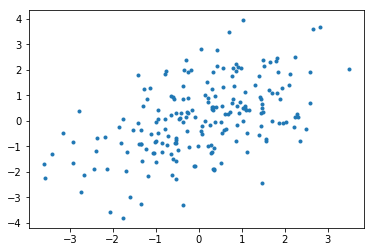

In [4]:
rnd = np.random.RandomState(0)
X = rnd.multivariate_normal(np.zeros(2), cov = np.array([[2,1],[1,2]]), size=200)
plt.plot(X[:,0],X[:,1],'.')
plt.show()

Because the data is two-dimensional, the only meaningful choice of the latent variables dimension is $m=1$.

We perform the three methods of PCA, and compare the results in two ways: 

1. $C$ matrix, which governs the predictive distribution, and defined by
$$
\begin{align}
    C := W W^T + \sigma^2 I_d. 
\end{align}
$$
Note that $W$ is not unique in maximum-likelihood estimation, and hence directly comparing $W$ is not meaningful.
2. Graphically looking at generated samples

In [5]:
max_iter = 1000

mlpca1 = MLPCA(m=1)
mlpca1.fit(X=X, method='analytical')

mlpca2 = MLPCA(m=1)
mlpca2.fit(X=X, method='em', disp_message=True, tol=1e-6, max_iter=max_iter)

bpca = BPCA(m=1)
bpca.fit(X=X, disp_message=True, tol=1e-6, max_iter=max_iter)

n_iter : 32
converged : True
n_iter : 32
converged : True


In [6]:
def calc_cmat(pca):
    W = pca.W
    variance = pca.variance
    d = len(W)
    return W @ (W.T) + variance*np.eye(d)

In [7]:
C1 = calc_cmat(mlpca1)
C2 = calc_cmat(mlpca2)
C3 = calc_cmat(bpca)

print(np.linalg.norm(C1 - C2))
print(np.linalg.norm(C1 - C3))

2.6651931942223766e-06
0.04384689691566826


We can see that the difference between the two maximum-likelihood approaches are almost negligible, as expected. 

In [8]:
def plot_2dim_pca(ax, pca, X):
    N = len(X)
    
    rnd = np.random.RandomState(1)
    Z = rnd.multivariate_normal(np.zeros(1), cov=np.eye(1), size=N)
    X_mean, X_cov = pca.inverse_transform(Z=Z, return_cov=True)
    rnd = np.random.RandomState(2)
    noise = rnd.multivariate_normal(np.zeros(2), cov=X_cov, size=N)
    Xsample = X_mean + noise

    ax.plot(X[:, 0], X[:, 1], 'o', label='original data')
    ax.plot(X_mean[:,0], X_mean[:,1], label='low dimensional subset')
    ax.plot(Xsample[:,0], Xsample[:,1], '.', label='generated samples')
    ax.legend()

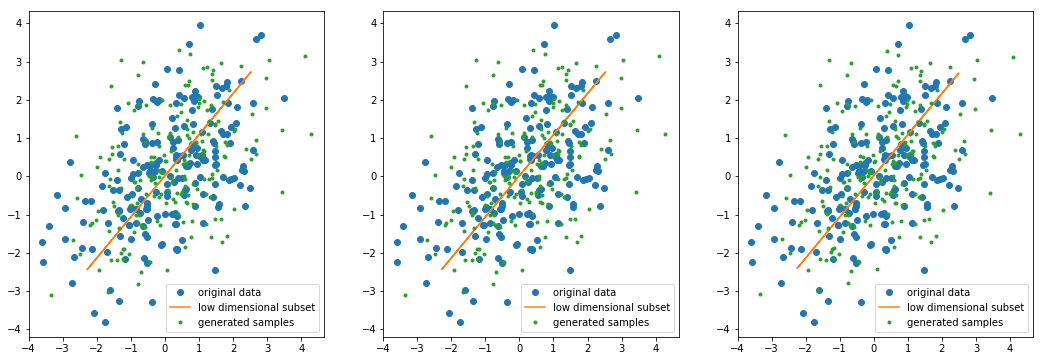

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_2dim_pca(axes[0], mlpca1, X)
plot_2dim_pca(axes[1], mlpca2, X)
plot_2dim_pca(axes[2], bpca, X)

It seems that there are no visible differences between these three results, in terms of the generated data.

## 4.2 High dimensional data

Next, to see the benefit of the Bayesian approach, we shall consider a higher dimensional data.

More speicfically, we assume that the data is 10 dimensional, and obey a Gaussian distribution, which has large variance in three directions.

In [10]:
N = 300
D = 10
var = np.array([1.0, 0.1, 1.0, 0.1, 0.1, 0.1, 0.1, 0.1, 1.0, 0.1])
rnd = np.random.RandomState(0)
X = rnd.multivariate_normal(np.zeros(D), cov=np.diag(var), size=N)

We compare the result by visualizing $\| w_i \|$, and see how many degrees of freedom is remaining or suppressed.

In [11]:
def plot_magnitude_of_coefficients(ax, pcas, labels):
    for i in range(len(pcas)):
        Wsize = np.linalg.norm(pcas[i].W, axis = 0)**2
        ax.plot(np.sort(Wsize)[::-1], 'o-', label=labels[i])
    ax.set_yscale('log')
    ax.set_xlabel(r'$i$')
    ax.set_ylabel(r'$\|w_i\|^2$')
    ax.legend()

C:\Users\sokohaku\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars


n_iter : 49
converged : True


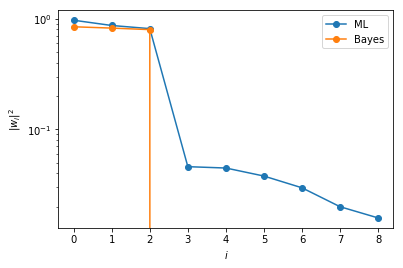

In [12]:
m = 9
mlpca = MLPCA(m=m)
mlpca.fit(X, method='analytical')
bpca = BPCA(m=m)
bpca.fit(X, max_iter=1000, tol=1e-5, disp_message=True)

ax = plt.subplot(111)
plot_magnitude_of_coefficients(ax, [mlpca, bpca], ['ML', 'Bayes'])

It can be clearly seen that the Bayesian approach suppresses redundant degrees of freedom.

## 4.3 Hand-written digits

Next, we consider hand-written digits data of the digit three.


In [13]:
from sklearn import datasets
digits = datasets.load_digits()

threes = digits.data[np.where(digits.target==3)]/16.0 # extracting the data corresponding threes, and perform scaling
print(f"The number of data points : {len(threes)}")
print(f"The dimension of the observables : {len(threes[0])}")

The number of data points : 183
The dimension of the observables : 64


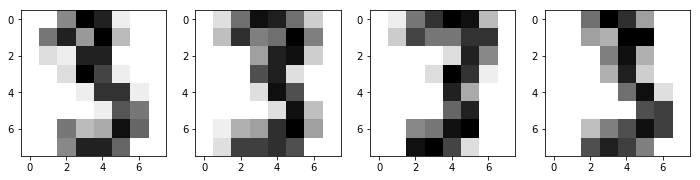

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for (i, ax) in  enumerate(axes):
    ax.imshow(threes[i].reshape((8,8)), cmap='gray_r') 

C:\Users\sokohaku\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars


n_iter : 3532
converged : True


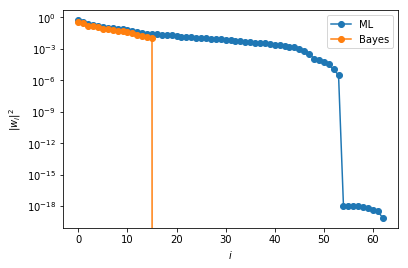

In [16]:
m = 63
max_iter = 10000

mlpca = MLPCA(m=m)
mlpca.fit(threes)

bpca = BPCA(m=m)
bpca.fit(threes, disp_message=True, max_iter=max_iter, tol=1e-4)

ax = plt.subplot(111)
plot_magnitude_of_coefficients(ax, [mlpca, bpca], ['ML', 'Bayes'])

Again, we can see that the Bayesian approach suppresses redundant degrees of freedom.